In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("pastel")

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 

In [2]:
df = pd.read_csv('./Tree_Data.csv')

# X -> Alive (1), NaN -> not alive (0)
df.Alive = df.Alive.apply(lambda x: 1 if x == 'X' else 0)

df.Harvest = df.Harvest.apply(lambda x: 1 if x == 'X' else 0)

df.head()

,No,Plot,Subplot,Species,Light_ISF,Light_Cat,Core,Soil,Adult,Sterile,...,AMF,EMF,Phenolics,Lignin,NSC,Census,Time,Event,Harvest,Alive
0,126,1,C,Acer saccharum,0.106,Med,2017,Prunus serotina,I,Non-Sterile,...,22.00,NaN,-0.56,13.86,12.15,4,14.0,1.0,0,0
1,11,1,C,Quercus alba,0.106,Med,2017,Quercus rubra,970,Non-Sterile,...,15.82,31.07,5.19,20.52,19.29,33,115.5,0.0,0,1
2,12,1,C,Quercus rubra,0.106,Med,2017,Prunus serotina,J,Non-Sterile,...,24.45,28.19,3.36,24.74,15.01,18,63.0,1.0,0,0
3,2823,7,D,Acer saccharum,0.080,Med,2016,Prunus serotina,J,Non-Sterile,...,22.23,NaN,-0.71,14.29,12.36,4,14.0,1.0,0,0
4,5679,14,A,Acer saccharum,0.060,Low,2017,Prunus serotina,689,Non-Sterile,...,21.15,NaN,-0.58,10.85,11.20,4,14.0,1.0,0,0


In [3]:
print(f"Alive Percentage: {np.round(df.Alive.mean(), 4) * 100}")

Alive Percentage: 17.64


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2783 entries, 0 to 2782
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   No           2783 non-null   int64  
 1   Plot         2783 non-null   int64  
 2   Subplot      2783 non-null   object 
 3   Species      2783 non-null   object 
 4   Light_ISF    2783 non-null   float64
 5   Light_Cat    2783 non-null   object 
 6   Core         2783 non-null   int64  
 7   Soil         2783 non-null   object 
 8   Adult        2783 non-null   object 
 9   Sterile      2783 non-null   object 
 10  Conspecific  2783 non-null   object 
 11  Myco         2783 non-null   object 
 12  SoilMyco     2783 non-null   object 
 13  PlantDate    2783 non-null   object 
 14  AMF          2783 non-null   float64
 15  EMF          1283 non-null   float64
 16  Phenolics    2783 non-null   float64
 17  Lignin       2783 non-null   float64
 18  NSC          2783 non-null   float64
 19  Census

In [5]:
# notice the large amount of missing data for EMF above, since we don't know why this is missing or how
# it should be filled in (ex: mean, median, or 0), we're going to drop this data.
# Let's drop other unimportant columns while we're at it
df.drop(labels = ['EMF', 'Time', 'No', 'Event', 'Census', 'Core', 'Harvest', 'Plot'], axis = 1, inplace = True)

In [6]:
df.head()

,Subplot,Species,Light_ISF,Light_Cat,Soil,Adult,Sterile,Conspecific,Myco,SoilMyco,PlantDate,AMF,Phenolics,Lignin,NSC,Alive
0,C,Acer saccharum,0.106,Med,Prunus serotina,I,Non-Sterile,Heterospecific,AMF,AMF,6/11/18,22.00,-0.56,13.86,12.15,0
1,C,Quercus alba,0.106,Med,Quercus rubra,970,Non-Sterile,Heterospecific,EMF,EMF,5/25/18,15.82,5.19,20.52,19.29,1
2,C,Quercus rubra,0.106,Med,Prunus serotina,J,Non-Sterile,Heterospecific,EMF,AMF,5/31/18,24.45,3.36,24.74,15.01,0
3,D,Acer saccharum,0.080,Med,Prunus serotina,J,Non-Sterile,Heterospecific,AMF,AMF,6/11/18,22.23,-0.71,14.29,12.36,0
4,A,Acer saccharum,0.060,Low,Prunus serotina,689,Non-Sterile,Heterospecific,AMF,AMF,6/11/18,21.15,-0.58,10.85,11.20,0


# Categorical Variable Analysis

## Species

In [7]:
df.Species.value_counts()

Acer saccharum     751
Prunus serotina    749
Quercus alba       673
Quercus rubra      610
Name: Species, dtype: int64

In [8]:
species_group = df.groupby('Species').mean().reset_index()
species_group

,Species,Light_ISF,AMF,Phenolics,Lignin,NSC,Alive
0,Acer saccharum,0.085614,15.279601,-0.091704,12.584993,11.832051,0.001332
1,Prunus serotina,0.085567,31.214206,0.525848,7.837356,10.867797,0.026702
2,Quercus alba,0.086000,16.377741,4.436553,20.329851,19.875973,0.383358
3,Quercus rubra,0.085669,18.561557,3.391869,24.354098,15.034230,0.347541


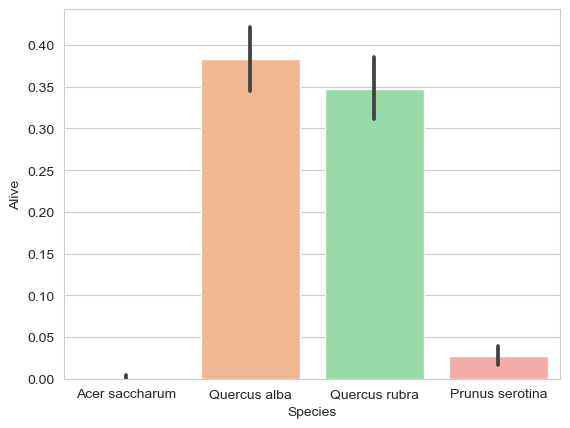

In [9]:
plt.figure()
sns.barplot(data = df, x = 'Species', y = 'Alive')
plt.show()

## Light_Cat

In [10]:
light_group = df.groupby('Light_Cat').mean()
light_group

,Light_ISF,AMF,Phenolics,Lignin,NSC,Alive
Light_Cat,,,,,,
High,0.137507,24.340230,2.427303,16.494638,15.760164,0.190789
Low,0.060985,19.853592,1.763940,15.112010,12.862070,0.156219
Med,0.091879,20.248915,1.946520,16.049905,14.827537,0.187246


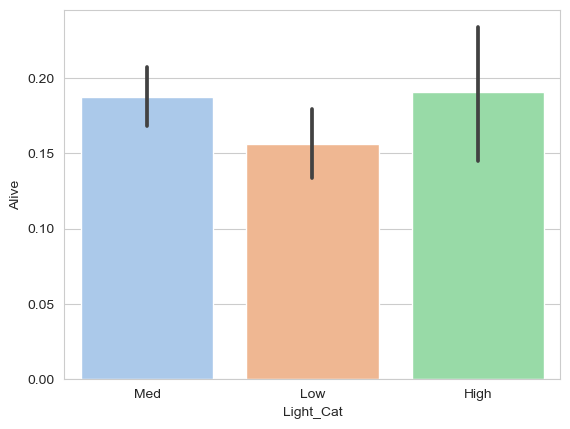

In [11]:
plt.figure()
sns.barplot(data = df, x = 'Light_Cat', y = 'Alive')
plt.show()

There is no significant different in survival rate between light categories

## Soil

In [12]:
df.groupby('Soil').mean()

,Light_ISF,AMF,Phenolics,Lignin,NSC,Alive
Soil,,,,,,
Acer rubrum,0.085902,19.433856,1.785266,15.398431,14.192048,0.202128
Acer saccharum,0.085950,26.767733,2.258791,16.019295,14.513804,0.163728
Populus grandidentata,0.085197,24.832046,2.064322,14.782353,14.538286,0.173913
Prunus serotina,0.085983,22.621719,1.599443,16.069613,14.290533,0.191283
Quercus alba,0.086113,20.170157,2.055249,15.754278,14.315249,0.141732
Quercus rubra,0.085858,21.289005,2.186866,16.491194,13.896144,0.184080
Sterile,0.084998,9.385721,1.612151,15.748322,13.825650,0.177305


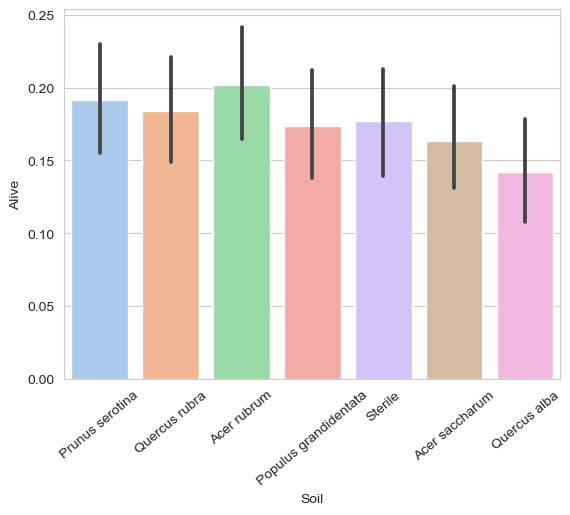

In [13]:
plt.figure()

ax = sns.barplot(data = df, x = 'Soil', y = 'Alive')
ax.tick_params(axis = 'x', labelrotation = 40)
plt.show()

There is no significant different in survival rate between the types of soil used for a tree

## Sterility 

In [14]:
df.groupby('Sterile').mean()

,Light_ISF,AMF,Phenolics,Lignin,NSC,Alive
Sterile,,,,,,
Non-Sterile,0.085834,22.554674,1.990631,15.761847,14.290258,0.176271
Sterile,0.084998,9.385721,1.612151,15.748322,13.825650,0.177305


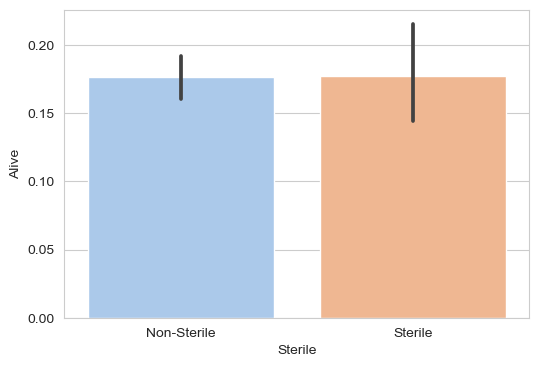

In [15]:
plt.figure(figsize = (6,4))
sns.barplot(data = df, x = 'Sterile', y = 'Alive')
plt.show()

## Conspecific

In [16]:
df.groupby('Conspecific').mean()

,Light_ISF,AMF,Phenolics,Lignin,NSC,Alive
Conspecific,,,,,,
Conspecific,0.086756,21.324404,1.956995,16.369896,13.330415,0.137306
Heterospecific,0.085653,22.795243,1.997209,15.642948,14.477948,0.183891
Sterilized,0.084998,9.385721,1.612151,15.748322,13.825650,0.177305


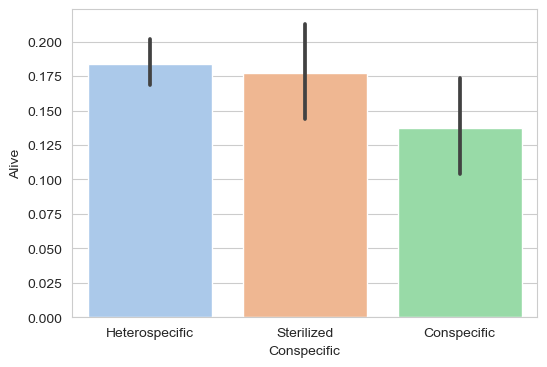

In [17]:
plt.figure(figsize = (6,4))
sns.barplot(data = df, x = 'Conspecific', y = 'Alive')
plt.show()

## Myco

In [18]:
df.Myco.value_counts()

AMF    1500
EMF    1283
Name: Myco, dtype: int64

In [19]:
df.groupby('Myco').mean()

,Light_ISF,AMF,Phenolics,Lignin,NSC,Alive
Myco,,,,,,
AMF,0.085591,23.236280,0.21666,10.214340,11.350567,0.014000
EMF,0.085843,17.416033,3.93986,22.243172,17.573975,0.366329


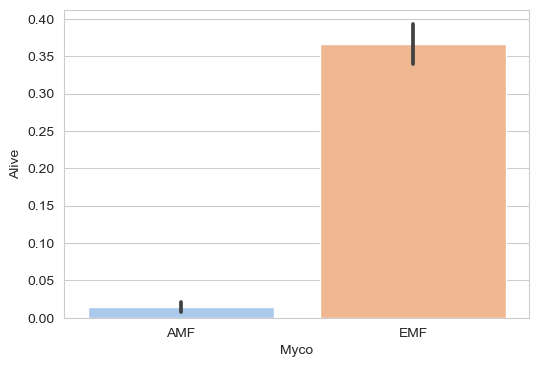

In [20]:
plt.figure(figsize = (6,4))
sns.barplot(data = df, x = 'Myco', y = 'Alive')
plt.show()

In [21]:
df.groupby('SoilMyco').mean()

,Light_ISF,AMF,Phenolics,Lignin,NSC,Alive
SoilMyco,,,,,,
AMF,0.085946,22.998895,1.879064,15.839983,14.334047,0.185497
EMF,0.085721,22.105911,2.103339,15.682913,14.246022,0.166951
Sterile,0.084998,9.385721,1.612151,15.748322,13.825650,0.177305


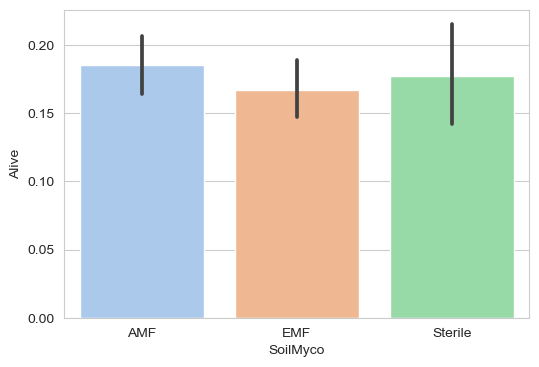

In [22]:
plt.figure(figsize = (6,4))
sns.barplot(data = df, x = 'SoilMyco', y = 'Alive')
plt.show()

The only two important categorical variables which survival seems to be dependent on are: 
> 1. Species <br>
> 2. Myco

# Numerical Variable Exploration

In [23]:
df.groupby('Alive').mean()

,Light_ISF,AMF,Phenolics,Lignin,NSC
Alive,,,,,
0,0.085197,21.029756,1.515611,14.620803,13.408944
1,0.088088,18.327882,3.881976,21.076619,18.003992


## AMF

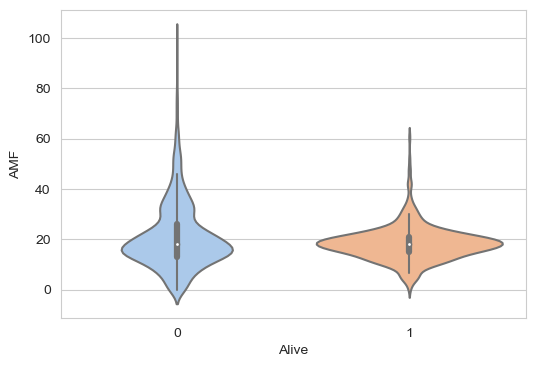

In [24]:
plt.figure(figsize = (6,4))

sns.violinplot(data = df, x = 'Alive', y = 'AMF')
plt.show()

## Phenolics

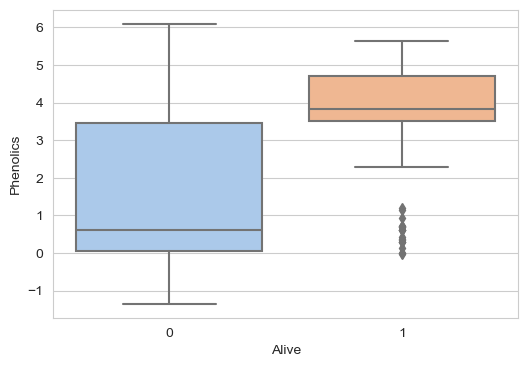

In [25]:
plt.figure(figsize = (6,4))

sns.boxplot(data = df, x = 'Alive', y = 'Phenolics')
plt.show()

## Lignin

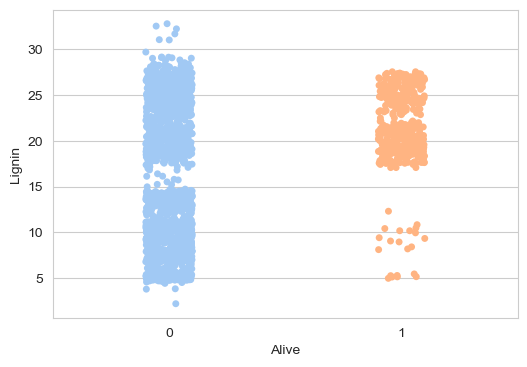

In [26]:
plt.figure(figsize = (6,4))

sns.stripplot(data = df, x = 'Alive', y = 'Lignin')
plt.show()

## NSC

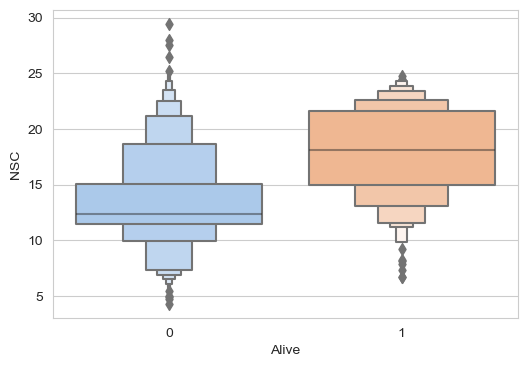

In [27]:
plt.figure(figsize = (6,4))

sns.boxenplot(data = df, x = 'Alive', y = 'NSC')
plt.show()

# Feature Selection

Based on the exploratary analysis above, we are going to select the following variables to be included in our modeling.

<ul>
    <li>
        Species
    </li>    
    <li>
        Myco
    </li> 
    <li>
        AMF
    </li> 
    <li>
        Phenolics
    </li> 
    <li>
        Lignin
    </li> 
    <li>
        NSC
    </li> 
</ul>

# Create Data Pipelines

In [28]:
cat_vars = ['Species', 'Myco']

survival_cat = df[cat_vars]

cat_pipeline = Pipeline([
    ('categorical encoder', OneHotEncoder()) # get one hot values
])

survival_cat_tr = cat_pipeline.fit_transform(survival_cat)
survival_cat_tr = survival_cat_tr.toarray()
survival_cat_tr

array([[1., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 1., 0., 1.],
       ...,
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 1., 0.]])

In [29]:
num_vars = ['AMF', 'Phenolics', 'Lignin', 'NSC']

survival_num = df[num_vars]

num_pipeline = Pipeline([
    ('scale', StandardScaler())
])

survival_num_tr = num_pipeline.fit_transform(survival_num)
survival_num_tr

array([[ 0.1175662 , -1.26586428, -0.28027184, -0.48159192],
       [-0.38457172,  1.65367617,  0.70226249,  1.17983963],
       [ 0.31663382,  0.72450069,  1.3248293 ,  0.18391147],
       ...,
       [-0.6982048 ,  1.81615494,  0.79225438,  1.13562787],
       [-0.28950678,  1.19162716,  0.53408094,  1.66151516],
       [ 3.24252163, -0.47378026, -0.99135525, -0.55838077]])

## Full Pipeline

In [30]:
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_vars),
    ('cat', cat_pipeline, cat_vars)
])

data_prepared = full_pipeline.fit_transform(df)
data_prepared

array([[ 0.1175662 , -1.26586428, -0.28027184, ...,  0.        ,
         1.        ,  0.        ],
       [-0.38457172,  1.65367617,  0.70226249, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.31663382,  0.72450069,  1.3248293 , ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-0.6982048 ,  1.81615494,  0.79225438, ...,  0.        ,
         0.        ,  1.        ],
       [-0.28950678,  1.19162716,  0.53408094, ...,  0.        ,
         0.        ,  1.        ],
       [ 3.24252163, -0.47378026, -0.99135525, ...,  0.        ,
         1.        ,  0.        ]])

# Machine Learning Model

In [31]:
X = data_prepared
y = df['Alive']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .9, random_state = 21)

xgb = XGBClassifier(n_estimators = 100, max_depth = 10, gamma = 10, learning_rate = .1)

In [32]:
xgb.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=10, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [33]:
predictions = xgb.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8781362007168458
Precision: 0.8181818181818182
Recall: 0.375


# Hypertune Parameters using Cross-Validation

In [34]:
# perform grid search to tune hyperparameters
params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [4, 6],
    "gamma": [1, 5],
    "learning_rate": [.01, .05]
}

xgb = XGBClassifier()

grid = GridSearchCV(xgb, param_grid = params)
grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...e,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_chil

In [35]:
grid.best_params_

{'gamma': 1, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}

In [36]:
# retrain model with the hypertuned parameters
tuned_model = XGBClassifier(n_estimators = grid.best_params_["max_depth"], max_depth = grid.best_params_["n_estimators"],
                      gamma = grid.best_params_["gamma"], learning_rate = grid.best_params_["learning_rate"])
tuned_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=200, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=6, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [37]:
predictions = tuned_model.predict(X_test)

tuned_accuracy = accuracy_score(y_test, predictions)
tuned_precision = precision_score(y_test, predictions)
tuned_recall = recall_score(y_test, predictions)

print("Accuracy:", tuned_accuracy)
print("Precision:", tuned_precision)
print("Recall:", tuned_recall)

Accuracy: 0.8422939068100358
Precision: 0.54
Recall: 0.5625


In [38]:
metrics_df = pd.DataFrame(data = [[accuracy, precision, recall], [tuned_accuracy, tuned_precision, tuned_recall]],
                 index = ['Before Tuning', 'After Tuning'],
                 columns = ['Accuracy', 'Precision', 'Recall'])

metrics_df

,Accuracy,Precision,Recall
Before Tuning,0.878136,0.818182,0.3750
After Tuning,0.842294,0.540000,0.5625
